In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input



In [2]:
# Define paths
show_frames_path = "C:\\Users\\Administrator\\Desktop\\Full_data_both_channels\\full_data_adbreak"
commercial_frames_path = "C:\\Users\\Administrator\\Desktop\\Full_data_both_channels\\full_data_show"

# Parameters
image_size = (128, 128)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
def preprocess_and_augment_images(images):
    images = images.astype('float32') / 255.0
    augmented_images = []
    for image in images:
        augmented_images.append(datagen.random_transform(image))
    return np.array(augmented_images)

In [5]:
def image_generator(files, label, image_size, batch_size):
    num_files = len(files)
    while True:
        for start in range(0, num_files, batch_size):
            end = min(start + batch_size, num_files)
            batch_files = files[start:end]
            images = []
            labels = []
            for filename in batch_files:
                img = load_img(filename, target_size=image_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
            images = preprocess_and_augment_images(np.array(images))
            labels = to_categorical(np.array(labels), num_classes=2)
            yield (images, labels)

def combined_generator(show_files, commercial_files, batch_size):
    show_gen = image_generator(show_files, 0, image_size, batch_size)
    commercial_gen = image_generator(commercial_files, 1, image_size, batch_size)
    while True:
        show_images, show_labels = next(show_gen)
        commercial_images, commercial_labels = next(commercial_gen)
        all_images = np.concatenate((show_images, commercial_images), axis=0)
        all_labels = np.concatenate((show_labels, commercial_labels), axis=0)
        yield (all_images, all_labels)


In [6]:
# Load all files
show_files = [os.path.join(show_frames_path, f) for f in os.listdir(show_frames_path)]
commercial_files = [os.path.join(commercial_frames_path, f) for f in os.listdir(commercial_frames_path)]

In [7]:
# Split data into training, validation, and test sets
show_train, show_test = train_test_split(show_files, test_size=0.2, random_state=42)
show_train, show_val = train_test_split(show_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [8]:
commercial_train, commercial_test = train_test_split(commercial_files, test_size=0.2, random_state=42)
commercial_train, commercial_val = train_test_split(commercial_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [9]:
# Define batch size
batch_size = 32

In [10]:
# Create generators
train_generator = combined_generator(show_train, commercial_train, batch_size)
val_generator = combined_generator(show_val, commercial_val, batch_size)
test_generator = combined_generator(show_test, commercial_test, batch_size)

In [11]:
# Define the optimized CNN model
def create_optimized_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model


In [12]:
input_shape = (128, 128, 3)
model = create_optimized_cnn_model(input_shape)

In [13]:
# Compile the optimized model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Calculate steps per epoch
num_train_images = len(show_train) + len(commercial_train)
num_val_images = len(show_val) + len(commercial_val)
num_test_images = len(show_test) + len(commercial_test)
steps_per_epoch = num_train_images // batch_size
validation_steps = num_val_images // batch_size
test_steps = num_test_images // batch_size

In [15]:
# Train the model using the generator
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10,
                    validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1718s 2s/step - accuracy: 0.8608 - loss: 0.4042 - val_accuracy: 0.8251 - val_loss: 0.6206
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 3564s 4s/step - accuracy: 0.9373 - loss: 0.1608 - val_accuracy: 0.8970 - val_loss: 0.3327
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 4857s 6s/step - accuracy: 0.9527 - loss: 0.1264 - val_accuracy: 0.9124 - val_loss: 0.2824
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 5253s 6s/step - accuracy: 0.9617 - loss: 0.1087 - val_accuracy: 0.9604 - val_loss: 0.1063
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 5143s 6s/step - accuracy: 0.9641 - loss: 0.0977 - val_accuracy: 0.9490 - val_loss: 0.1437
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1673s 2s/step - accuracy: 0.9688 - loss: 0.0865 - val_accuracy: 0.9465 - val_loss: 0.1552
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1605s 2s/step - accuracy: 0.9744 - loss: 0.0717 - val_accuracy: 0.9599 - val_loss: 0.0978
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1624s 2s/step - accuracy: 0.9749 - loss: 0.0705 - 

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

293/293 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9806 - loss: 0.0613
Test accuracy: 0.9813754558563232, Test loss: 0.057066529989242554


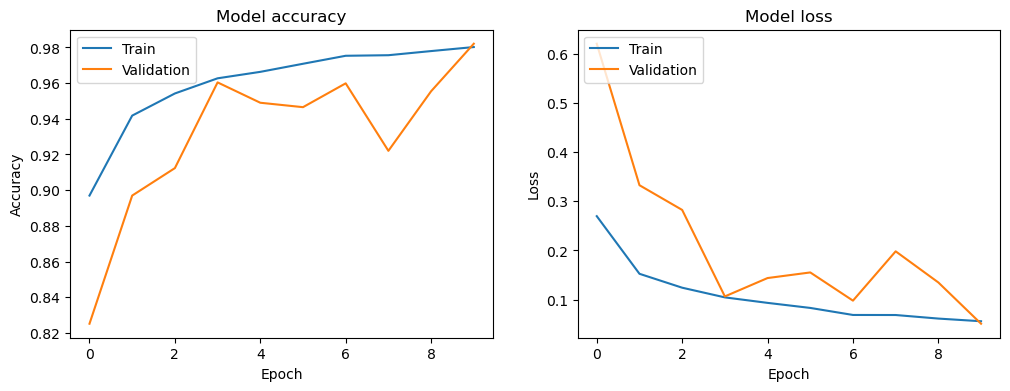

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
# Make predictions on the test data
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = y_pred.argmax(axis=-1)

293/293 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step


In [24]:
# Collect true labels
y_true = []
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_true.extend(y_batch.argmax(axis=-1))  # Convert one-hot encoded labels to class indices

# Convert the list to an array
y_true = np.array(y_true)

In [ ]:
# Initialize lists to store true labels and predictions
y_true = []
y_pred_classes = []

# Iterate over the generator to get predictions and true labels
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)  # Get a batch of data and labels
    y_true.extend(np.argmax(y_batch, axis=-1))  # Append true labels (converted from one-hot)
    predictions = model.predict(x_batch)  # Make predictions on the batch
    y_pred_classes.extend(np.argmax(predictions, axis=-1))  # Append predicted classes

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Increase epochs to allow early stopping to work effectively
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1743s 2s/step - accuracy: 0.9835 - loss: 0.0464 - val_accuracy: 0.9658 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1717s 2s/step - accuracy: 0.9853 - loss: 0.0411 - val_accuracy: 0.9529 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1692s 2s/step - accuracy: 0.9827 - loss: 0.0467 - val_accuracy: 0.9840 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1708s 2s/step - accuracy: 0.9850 - loss: 0.0423 - val_accuracy: 0.9688 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1694s 2s/step - accuracy: 0.9881 - loss: 0.0358 - val_accuracy: 0.9813 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 6/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1692s 2s/step - accuracy: 0.9851 - loss: 0.0416 - val_accuracy: 0.9879 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 7/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 1641s 2s/step - accuracy: 0.9876 - l

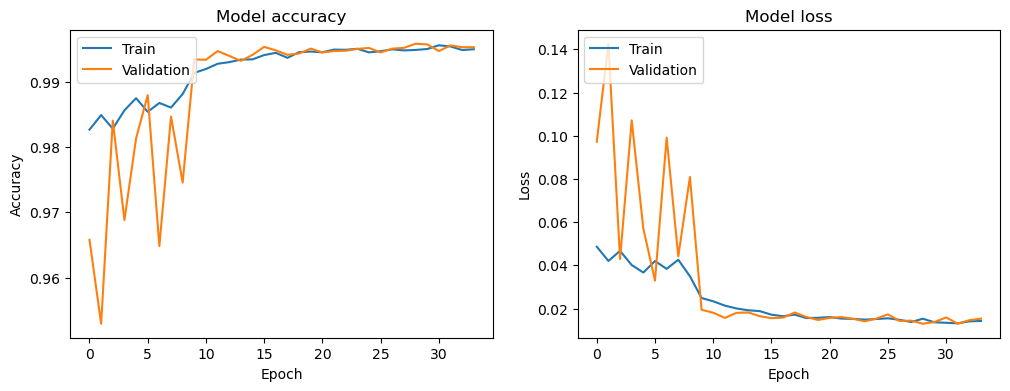

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Make predictions on the test data
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = y_pred.argmax(axis=-1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))
